In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from pathlib import Path
import numpy as np
import seaborn as sns
import result_handler as rh
from sklearn.metrics import confusion_matrix, f1_score, precision_score, accuracy_score, recall_score



In [15]:
RELOAD_DATA = True
RESULTS_DIR = Path('../translations')
RESULTS_NAME = 'cross_tests_results.csv'

if RELOAD_DATA:
    rh.concatenate_csv_files(RESULTS_DIR, 'predictions.csv', RESULTS_NAME)

df = pd.read_csv(RESULTS_NAME)

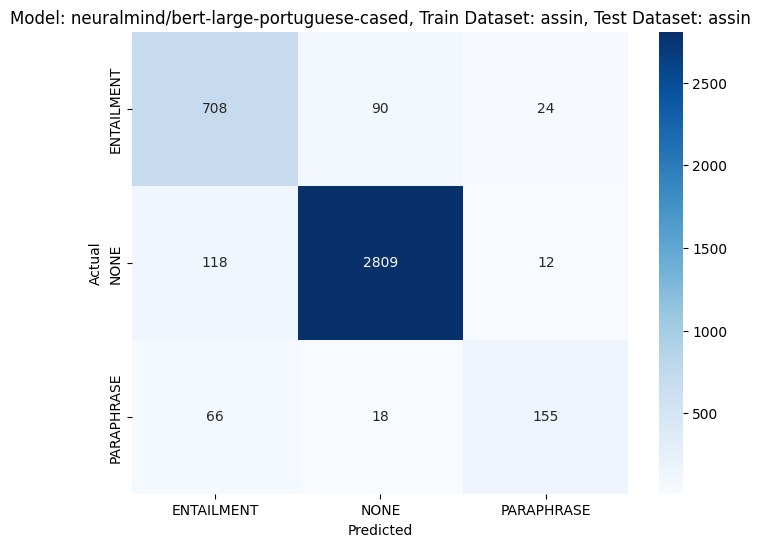

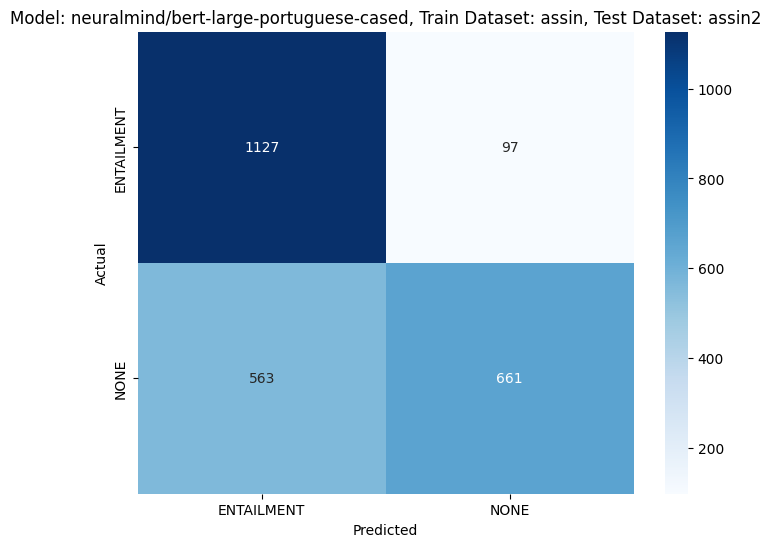

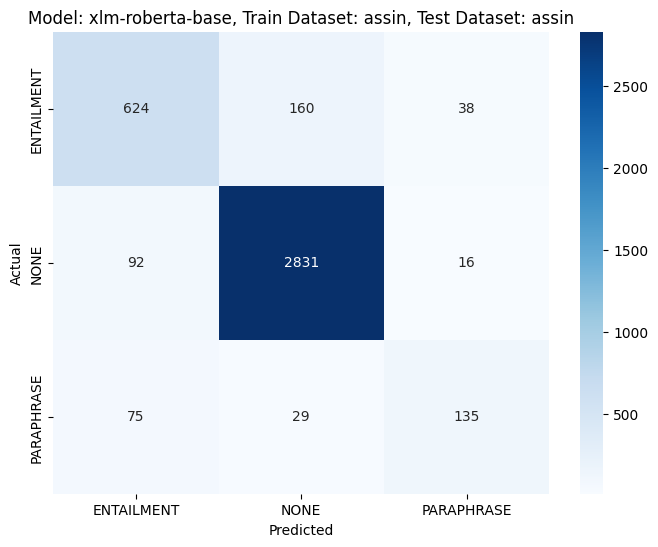

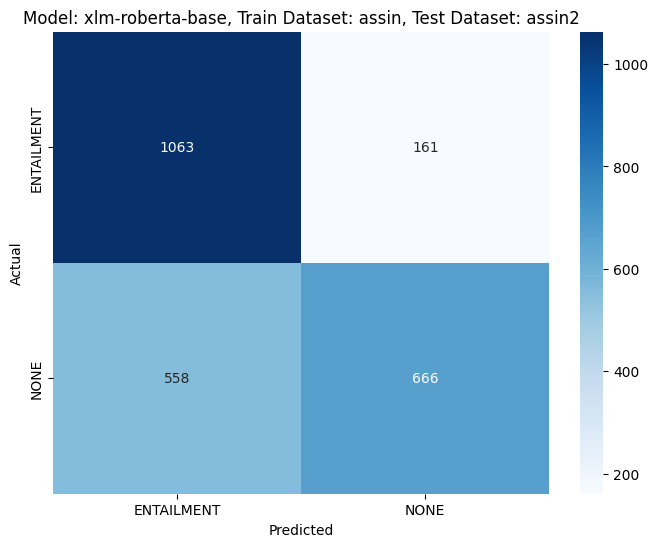

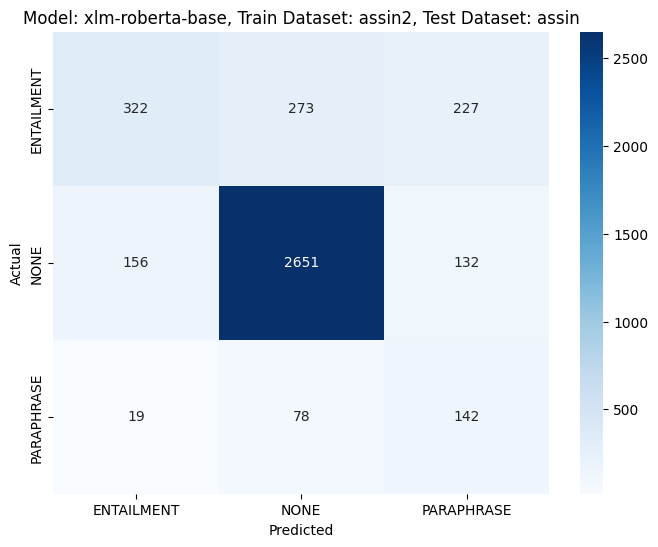

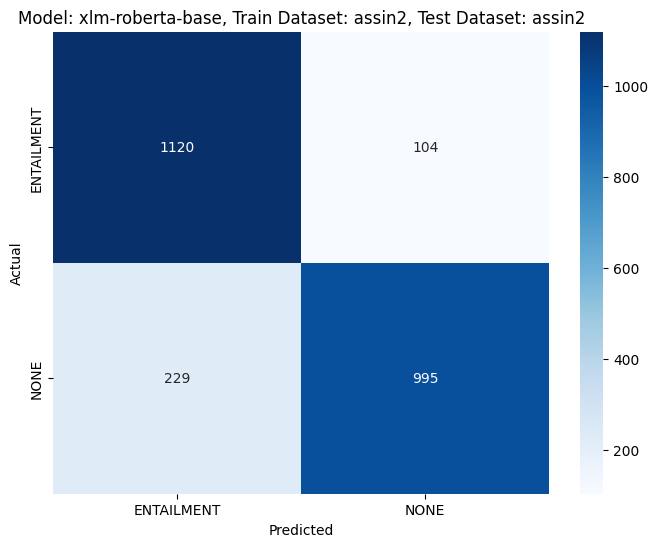

In [16]:
grouped = df.groupby(['model_name', 'train_dataset', 'test_dataset'])

for (model, train_ds, test_ds), group in grouped:
    # Compute confusion matrix
    labels = sorted(set(group['label'].unique().tolist() + group['prediction'].unique().tolist()))
    cm = confusion_matrix(group['label'], group['prediction'], labels=labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Model: {model}, Train Dataset: {train_ds}, Test Dataset: {test_ds}')
    plt.show()


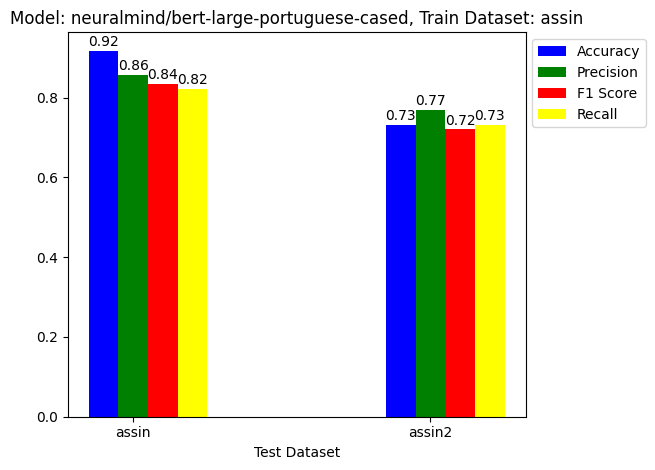

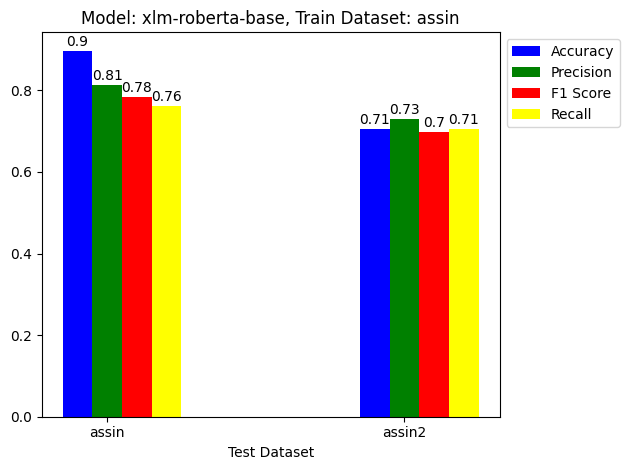

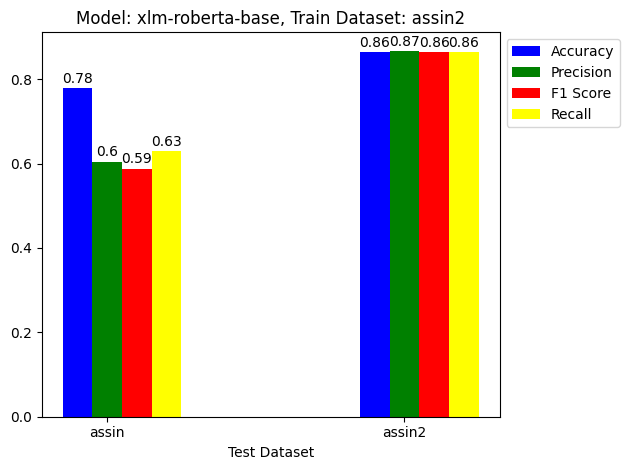

In [17]:
metrics_data = []

for (model, train_ds, test_ds), group in grouped:
    accuracy = accuracy_score(group['label'], group['prediction'])
    precision = precision_score(group['label'], group['prediction'], average='macro')
    f1 = f1_score(group['label'], group['prediction'], average='macro')
    recall = recall_score(group['label'], group['prediction'], average='macro')
    metrics_data.append((model, train_ds, test_ds, accuracy, precision, recall, f1))

# Convert to DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics_data, columns=['model_name', 'train_dataset', 'test_dataset', 'accuracy', 'precision','recall', 'f1'])

# Plotting
for (model, train_ds), group in metrics_df.groupby(['model_name', 'train_dataset']):
    # Setting the positions and width for the bars
    test_datasets = group['test_dataset'].unique()
    position = list(range(len(test_datasets)))
    width = 0.1

    bars1 = plt.bar(position, group['accuracy'], width=width, label='Accuracy', color='blue', align='center')
    bars2 = plt.bar([p + width for p in position], group['precision'], width=width, label='Precision', color='green', align='center')
    bars3 = plt.bar([p + width*2 for p in position], group['f1'], width=width, label='F1 Score', color='red', align='center')
    bars4 = plt.bar([p + width*3 for p in position], group['recall'], width=width, label='Recall', color='yellow', align='center')

    # Add text on top of bars
    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 2), ha='center', va='bottom')

    # Setting the labels for the x ticks
    plt.xticks([p + width for p in position], test_datasets)
    
    # Other plot settings
    plt.title(f'Model: {model}, Train Dataset: {train_ds}')
    plt.xlabel('Test Dataset')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    plt.tight_layout()
    plt.show()

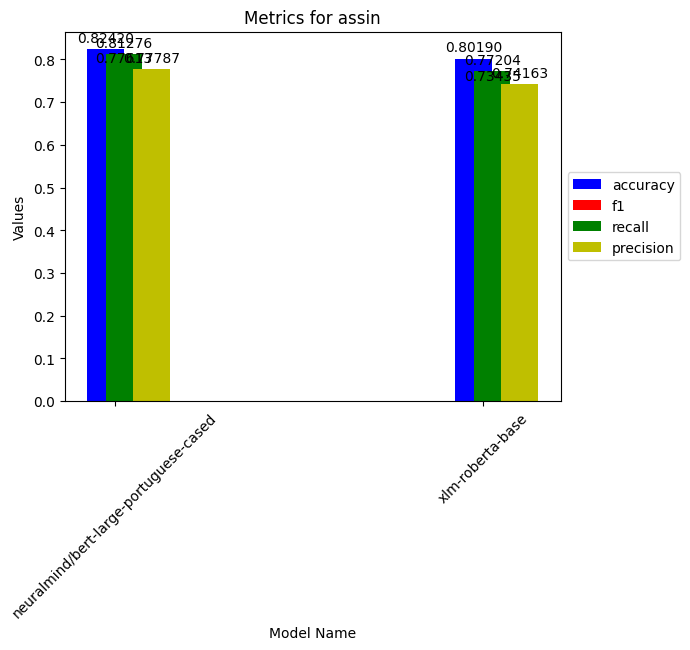

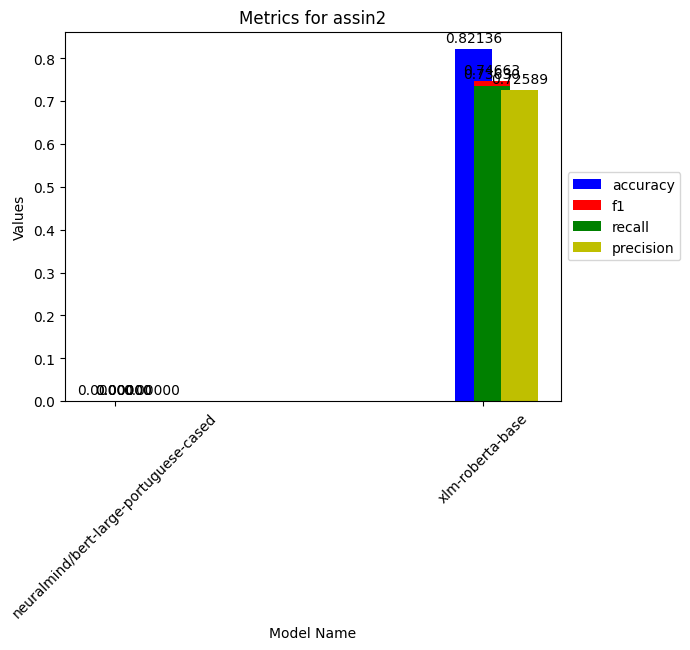

In [18]:
group_columns = ['train_dataset']
metrics_columns = ['accuracy', 'f1', 'recall', 'precision']
model_column = 'model_name'
models = df[model_column].unique()
models_dfs = {model : {group: None for group in group_columns} for model in models}
for model in models_dfs.keys():
    for group in group_columns:
        models_dfs[model][group] = metrics_df[metrics_df[model_column] == model].groupby([group])[metrics_columns].mean()

rh.plot_metrics_by_attribute(models_dfs, 'train_dataset')

In [19]:
metrics_df.to_csv('results.csv', index=False)